### Tarea: Creación de un Modelo de Clasificación para Predecir Problemas en Procesos de un Servidor

#### Objetivo
Desarrollar un modelo de clasificación que pueda predecir si un proceso en ejecución en un servidor causará problemas, basándose en datos históricos de los procesos. Este modelo ayudará en la detección temprana de procesos potencialmente problemáticos, permitiendo tomar acciones preventivas para asegurar la estabilidad y el rendimiento del servidor.

#### Datos
El conjunto de datos proporcionado incluye las siguientes características para cada proceso en el servidor:

- `ID_Proceso`: Identificador único del proceso.
- `Uso_CPU`: Porcentaje del CPU utilizado por el proceso.
- `Uso_Memoria`: Porcentaje de memoria utilizada por el proceso.
- `Numero_Hilos`: Número de hilos del proceso.
- `Tiempo_Ejecucion`: Tiempo de ejecución del proceso en horas.
- `Numero_Errores`: Número de errores generados por el proceso en las últimas 24 horas.
- `Tipo_Proceso`: Categoría del proceso (Servicio, Aplicación, Sistema).

La variable objetivo, `Estado`, indica si un proceso es problemático (1) o no (0), basada en el uso de recursos, número de errores, tipo de proceso, y otros factores relevantes.

#### Entrega
La tarea final consistirá en un Jupyter Notebook que contenga todo el código utilizado para el análisis, preprocesamiento de datos, modelado, y evaluación, junto con un reporte escrito (dentro del mismo notebook o como un documento separado) que resuma los hallazgos y las recomendaciones basadas en el modelo desarrollado.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as wr
wr.filterwarnings('ignore')

## 1) Análisis Exploratorio de Datos (EDA): 
Realice un análisis preliminar para entender la distribución y las características de los datos. Esto incluye verificar valores faltantes, la distribución de las variables numéricas, y la frecuencia de las categorías en variables categóricas.

In [2]:
# Carga de archivo
df=pd.read_csv("datos_procesos.csv", sep ='|')
df.head()

,ID_Proceso,Uso_CPU,Uso_Memoria,Numero_Hilos,Tiempo_Ejecucion,Numero_Errores,Tipo_Proceso,Estado
0,1,37.454012,59.515562,16,8.184879,3,Aplicación,0
1,2,95.071431,36.471714,18,76.195256,8,Aplicación,0
2,3,73.199394,0.537562,21,46.991138,3,Aplicación,0
3,4,59.865848,56.108773,28,87.884325,4,Aplicación,0
4,5,15.601864,89.657041,39,4.622599,1,Sistema,0


In [3]:
# hay un millon de filas y 8 columnas en el archivo
df.shape

(1000000, 8)

In [4]:
# información de columnas nombres y tipos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   ID_Proceso        1000000 non-null  int64  
 1   Uso_CPU           1000000 non-null  float64
 2   Uso_Memoria       1000000 non-null  float64
 3   Numero_Hilos      1000000 non-null  int64  
 4   Tiempo_Ejecucion  1000000 non-null  float64
 5   Numero_Errores    1000000 non-null  int64  
 6   Tipo_Proceso      1000000 non-null  object 
 7   Estado            1000000 non-null  int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 61.0+ MB


In [5]:
# Distribución, frecuencias, máximos y mínimos
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID_Proceso,1000000.0,500000.500000,288675.278933,1.000000,250000.750000,500000.500000,750000.250000,1000000.000000
Uso_CPU,1000000.0,50.033449,28.859113,0.000052,25.034021,50.055597,75.009673,99.999831
Uso_Memoria,1000000.0,49.947866,28.851514,0.000038,24.999623,49.895350,74.924148,99.999938
Numero_Hilos,1000000.0,25.030640,14.150159,1.000000,13.000000,25.000000,37.000000,49.000000
Tiempo_Ejecucion,1000000.0,50.043250,28.829111,0.100083,25.074789,50.040186,75.030119,99.999992
Numero_Errores,1000000.0,5.003483,2.237005,0.000000,3.000000,5.000000,6.000000,19.000000
Estado,1000000.0,0.064631,0.245874,0.000000,0.000000,0.000000,0.000000,1.000000


In [6]:
# revisando nulos: no hay nulos en ninguna columna
df.isnull().sum()

ID_Proceso          0
Uso_CPU             0
Uso_Memoria         0
Numero_Hilos        0
Tiempo_Ejecucion    0
Numero_Errores      0
Tipo_Proceso        0
Estado              0
dtype: int64

In [7]:
# revisando valores únicos: 
# ID_Proceso, Uso_CPU, Uso_Memoria y Tiempo_Ejecucion tienen valores unicos(no se repite ningún valor)
# Numero_Hilos: van desde 1 a 49 (49 valores distintos)
# Numero_errores: van desde 0 a 19 (20 valores distintos)
# Tipo_Proceso: 3 valores distintos. Aplicación, Sistema y Servicio
# Estado: 2 valores distintos. 0 y 1
df.nunique()

ID_Proceso          1000000
Uso_CPU             1000000
Uso_Memoria         1000000
Numero_Hilos             49
Tiempo_Ejecucion    1000000
Numero_Errores           20
Tipo_Proceso              3
Estado                    2
dtype: int64

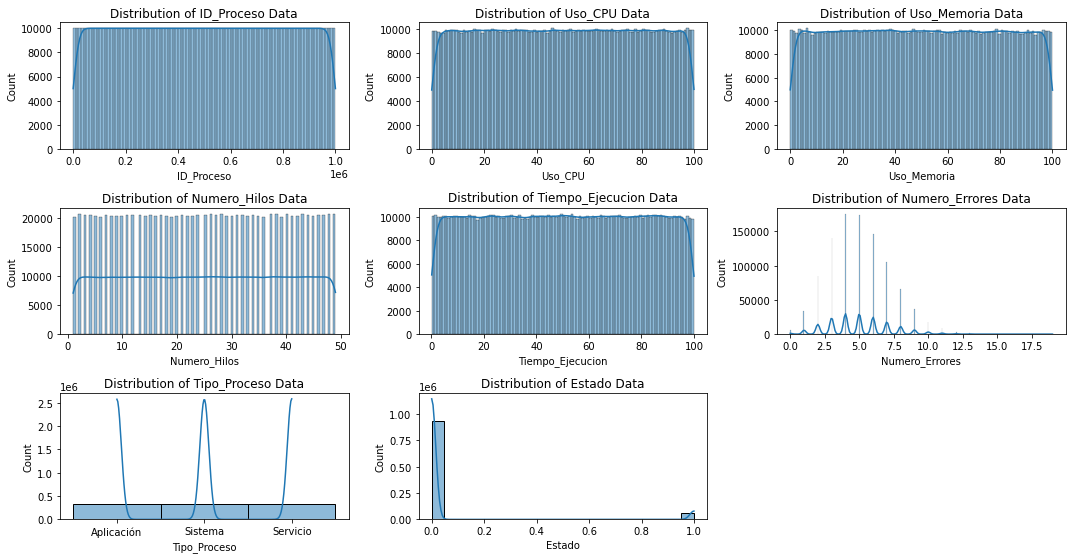

In [8]:
# gráficos de distribución y frecuencia
plt.figure(figsize=(15,10))
for i,col in enumerate(df.columns,1):
    plt.subplot(4,3,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(df[col],kde=True)
    plt.tight_layout()
    plt.plot()

In [9]:
df.Estado.value_counts(
    normalize = True # Normalizamos el resultado para obtener la proporción de las clases.
)

0    0.935369
1    0.064631
Name: Estado, dtype: float64

Sólo el 6.5 % de las observaciones pertenece a la clase 1(proceso problemático). <b> Será necesario hacer un balanceo

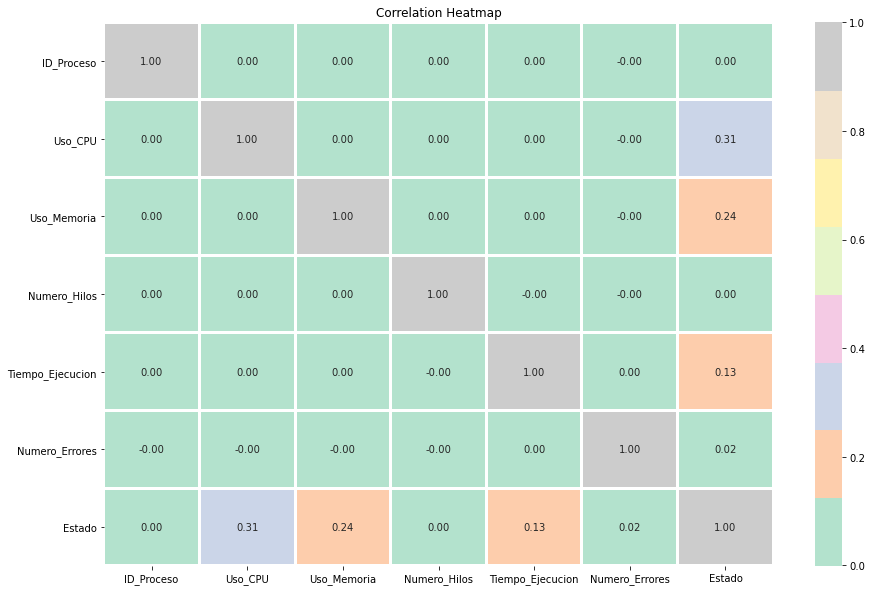

In [10]:
# Gráfico de correlación
plt.figure(figsize=(15, 10))

sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='Pastel2', linewidths=2)
 
plt.title('Correlation Heatmap')
plt.show()

#### Se observa una pequena correlación entre la variable estado y las variables: Uso_CPU, Uso_Memoria y Tiempo de Ejecución.

AxesSubplot(0.125,0.125;0.775x0.755)


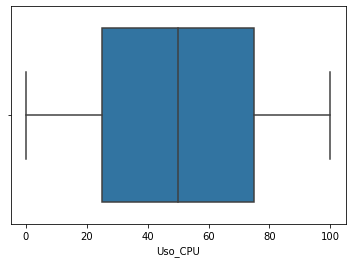

AxesSubplot(0.125,0.125;0.775x0.755)


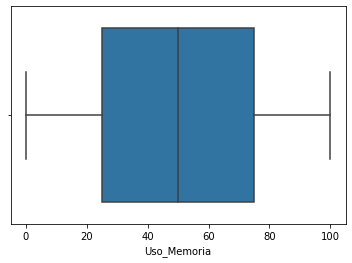

AxesSubplot(0.125,0.125;0.775x0.755)


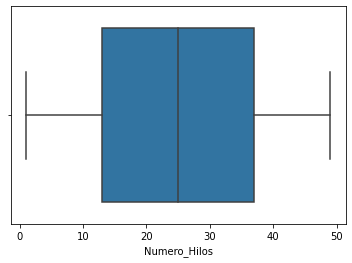

AxesSubplot(0.125,0.125;0.775x0.755)


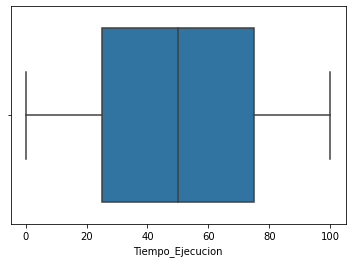

AxesSubplot(0.125,0.125;0.775x0.755)


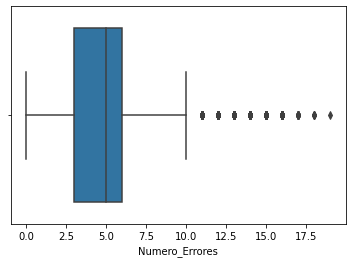

In [11]:
# Box plots
for col in df.columns.tolist():
    if col == 'Tipo_Proceso' or col == 'Estado' or col == 'ID_Proceso':
        continue
    else:
        print(sns.boxplot(df[col]))
        plt.show()

#### Podriamos considerar outliers los procesos con 14 o mas errores, ya cada uno representa menos del 0.05% de la población. Se podrían borrar o no. En este caso no borraremos estos registros.

In [12]:
# Calculando el porcentaje de la población que representa cada valor de la variable Numero_Errores
df_res = df['Numero_Errores'].value_counts(normalize=True).reset_index()
df_res['Numero_Errores'] = df_res['Numero_Errores']*100
df_res[df_res['index']>10]

,index,Numero_Errores
10,11,0.8352
12,12,0.3401
13,13,0.1364
14,14,0.0433
15,15,0.0171
16,16,0.0064
17,17,0.0014
18,18,0.0005
19,19,0.0001


## 2) Preprocesamiento de Datos:

Limpieza: Maneje valores faltantes y elimine duplicados si los hay.
Codificación de variables categóricas: Utilice técnicas como One-Hot Encoding para convertir Tipo_Proceso en variables numéricas.
Escalado de características: Normalice o escale las características numéricas para que tengan el mismo rango de valores, lo cual es importante para algunos modelos de clasificación.

In [13]:
# Revisando si hay procesos con datos duplicados
df = df.drop_duplicates(subset = ['ID_Proceso'])
len(df)

1000000

#### No hay valores faltantes ni duplicados

In [14]:
# Aplicando Enconding
from sklearn.preprocessing import LabelEncoder

print(df['Tipo_Proceso'])
le = LabelEncoder()
df['Tipo_Proceso'] = le.fit_transform(df['Tipo_Proceso'])
print(df['Tipo_Proceso'])

#se puede observar que los valores de la variable Tipo_Proceso se codificaron con los valores: 0,1,2

0         Aplicación
1         Aplicación
2         Aplicación
3         Aplicación
4            Sistema
             ...    
999995      Servicio
999996       Sistema
999997       Sistema
999998      Servicio
999999       Sistema
Name: Tipo_Proceso, Length: 1000000, dtype: object
0         0
1         0
2         0
3         0
4         2
         ..
999995    1
999996    2
999997    2
999998    1
999999    2
Name: Tipo_Proceso, Length: 1000000, dtype: int32


In [15]:
# Aplicando escalado
from sklearn.preprocessing import StandardScaler

# solo vamos a aplicar el escalado a las variables independientes numericas, se deja de lado ID_proceso
# ya que no predice es solo un id, tambien estado ya que es la variable a predecir
cols = df.iloc[:, [1,2,3,4,5]].columns
scaled_features = StandardScaler().fit_transform(df.iloc[:, [1,2,3,4,5]].values)
scaled_features_df = pd.DataFrame(scaled_features, index=df.index, columns=cols)

# agregamos al nuevo data frame las variable que no se escalaron
scaled_features_df['Tipo_Proceso'] = df['Tipo_Proceso']
scaled_features_df['ID_Proceso'] = df['ID_Proceso']
scaled_features_df['Estado'] = df['Estado']

# se muestran las variables escaladas
scaled_features_df.head()

,Uso_CPU,Uso_Memoria,Numero_Hilos,Tiempo_Ejecucion,Numero_Errores,Tipo_Proceso,ID_Proceso,Estado
0,-0.435892,0.331619,-0.638201,-1.451949,-0.895610,0,1,0
1,1.560616,-0.467087,-0.496860,0.907139,1.339523,0,2,0
2,0.802726,-1.712573,-0.284848,-0.105869,-0.895610,0,3,0
3,0.340704,0.213539,0.209847,1.312600,-0.448584,0,4,0
4,-1.193093,1.376330,0.987223,-1.575514,-1.789663,2,5,0


In [16]:
scaled_features_df.describe().T
# podemos ver que la desviación estandar es 1 y la media es cercana a 0 para todas las variables, 
# lo cual indica que el escalado se aplicó correctamente

,count,mean,std,min,25%,50%,75%,max
Uso_CPU,1000000.0,5.966680e-16,1.000001,-1.733713,-0.866258,0.000767,0.865454,1.731391
Uso_Memoria,1000000.0,-8.047275e-16,1.000001,-1.731204,-0.864712,-0.001820,0.865684,1.734817
Numero_Hilos,1000000.0,8.492173e-16,1.000001,-1.698260,-0.850213,-0.002165,0.845882,1.693930
Tiempo_Ejecucion,1000000.0,2.672313e-16,1.000001,-1.732388,-0.866085,-0.000106,0.866724,1.732858
Numero_Errores,1000000.0,-1.674931e-15,1.000000,-2.236690,-0.895610,-0.001557,0.445470,6.256815
Tipo_Proceso,1000000.0,9.999930e-01,0.816037,0.000000,0.000000,1.000000,2.000000,2.000000
ID_Proceso,1000000.0,5.000005e+05,288675.278933,1.000000,250000.750000,500000.500000,750000.250000,1000000.000000
Estado,1000000.0,6.463100e-02,0.245874,0.000000,0.000000,0.000000,0.000000,1.000000


## 3) Selección y División del Conjunto de Datos: 

Divida el conjunto de datos en entrenamiento, validación y prueba para evaluar la efectividad del modelo.

In [48]:
# División de los datos en entrenamiento y prueba
from sklearn.model_selection import train_test_split

X = scaled_features_df.iloc[:, [0,1,2,3,4,5]]# dejamos por fuera el ID_Proceso
y = scaled_features_df['Estado']

# los datos de test tendrán el 20% del total de la poblacion, los de entrenamiento el 70%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

#### Synthetic Minority Oversampling Technique + Submuestro de la clase mayoritaria + Balanceo parcial del conjunto de datos

Los autores de SMOTE recomiendan realizar paralelamente un submuestreo de la clase mayoritaria para poder obtener mejores resultados

In [63]:
import imblearn # Bilioteca para aprendizaje desde datos desbalanceados

sm = imblearn.over_sampling.SMOTE(sampling_strategy=0.3,random_state=11) # Hacemos SMOTe hasta obtener un balance de 30% de la clase minoritaria
rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.5,random_state=11) # Hacemos submuestreo hasta obtener un balance del 50%
steps = [('SMOTE', sm), ('RUS', rus)] # Ponemos ambos pasos
sm_rus = imblearn.pipeline.Pipeline(steps=steps) # Creamos un pipeline para realizar ambas tareas
X_train_sm_rus, y_train_sm_rus = sm_rus.fit_resample(X_train, y_train)

In [64]:
X_train_sm_rus.shape

(631341, 6)

In [65]:
y_train_sm_rus.shape

(631341,)

## 4) Construcción y Evaluación de Modelos:

Pruebe diferentes algoritmos de clasificación (por ejemplo, Regresión Logística, Árboles de Decisión, Bosques Aleatorios, y Máquinas de Soporte Vectorial) para encontrar el más adecuado.
Utilice validación cruzada para optimizar los hiperparámetros y evaluar la robustez del modelo.
Evalúe el modelo final utilizando el conjunto de prueba y métricas adecuadas (precisión, recall, puntuación F1, y curva ROC).

In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

# Entrenamiento y evaluación de los modelos
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    #"SVM" : SVC(kernel='linear'),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier()
}

# aqui se guardaran las métricas de cada modelo
results = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"])

# Se calculan las 5 metricas por cada modelo:
for name, model in models.items():
    model.fit(X_train_sm_rus, y_train_sm_rus)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    results.loc[name] = [accuracy, precision, recall, f1, roc_auc]
    print(classification_report(y_test, y_pred))

# Muestra los resultados
print(results)

              precision    recall  f1-score   support

           0       0.99      0.91      0.95    233876
           1       0.41      0.85      0.55     16124

    accuracy                           0.91    250000
   macro avg       0.70      0.88      0.75    250000
weighted avg       0.95      0.91      0.92    250000

              precision    recall  f1-score   support

           0       0.98      0.93      0.95    233876
           1       0.41      0.72      0.53     16124

    accuracy                           0.92    250000
   macro avg       0.70      0.83      0.74    250000
weighted avg       0.94      0.92      0.93    250000

              precision    recall  f1-score   support

           0       0.99      0.94      0.96    233876
           1       0.49      0.82      0.61     16124

    accuracy                           0.93    250000
   macro avg       0.74      0.88      0.79    250000
weighted avg       0.95      0.93      0.94    250000

              preci

El modelo mas adecuado y equilibrado para este problema es el Gradient Boosting ya que cuenta con el más alto Recall, en este caso es importante esta métrica ya que necesitamos identificar le mayor número posible de procesos problemáticos, se pueden generar algunos errores de indentificación por el bajo puntaje de Precision pero todos los demás modelos tienen puntaje mas bajo (a excepción de Random Forest). El Gradient Bossting tambien cuenta con el ROC_AUC mas alto lo cual tambien indica que es un buen Clasificador, en cuanto al Accuracy tiene el segundo puntaje mas alto.

In [69]:
# Aplicando K-fold cross-validation
from sklearn.model_selection import cross_val_score, KFold

scoring_list = ['accuracy','precision','recall','f1','roc_auc'] # lista de métricas a calcular
results_t = [] # lista para guardar los resultados de la media de cada métrica
results_mean = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]) # lista resultados totales
num_folds = 5 # de datasets de entrenamiento y prueba

# Validador cruzado K-Fold.
# Proporciona índices de entrenamiento/prueba para dividir datos en conjuntos de entrenamiento/prueba. 
# Divida el conjunto de datos en k pliegues consecutivos (sin barajar de forma predeterminada).
# Luego, cada pliegue se usa una vez como validación, mientras que los k - 1 pliegues restantes forman 
# el conjunto de entrenamiento.
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42) 
# random_state es para obtener una salida reproducible en multiples llamadas

for name, model in models.items():
    for metric in scoring_list:
        cross_val_results = cross_val_score(model, X_train_sm_rus, y_train_sm_rus, cv=kf, scoring = metric, n_jobs=-1) #Evalua una metrica mediante validación cruzada.
        results_t.append(cross_val_results.mean())
   
    results_mean.loc[name] = results_t
    results_t = []

# Muestra los resultados (media de cada métrica)
print(results_mean)

                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Logistic Regression  0.896116   0.835378  0.857294  0.846193  0.961170
Decision Tree        0.908585   0.856842  0.872151  0.864330  0.899309
Random Forest        0.939079   0.884808  0.939528  0.911247  0.983806
Gradient Boosting    0.916180   0.861955  0.891284  0.876374  0.973289
AdaBoost             0.911729   0.864763  0.871485  0.868108  0.971403


Despues de aplicar la validación cruzada los valores de Precision y el F1 para todos los modelos aumentaron bastante, esto es debido al Balanceo y la mismo algoritmo de validacion cruzada ya que entrena los modelos con varias combinaciones(N de Folds) de datos basadas en la data de entrenamiento ya balanceada. Es este caso escogeria el Random Forest es que que tiene las métricas mas altas.

## 5) Interpretación de Resultados y Conclusiones: 
Interprete los resultados del modelo en el contexto del problema. Identifique las características más importantes que influyen en la predicción de procesos problemáticos y discuta cómo se puede utilizar el modelo en un entorno de producción.

#### Variables que mas influyen en la predicción

In [ ]:
import shap

# Visualización de las características más importantes usando SHAP
explainer = shap.Explainer(models["Gradient Boosting"].predict, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

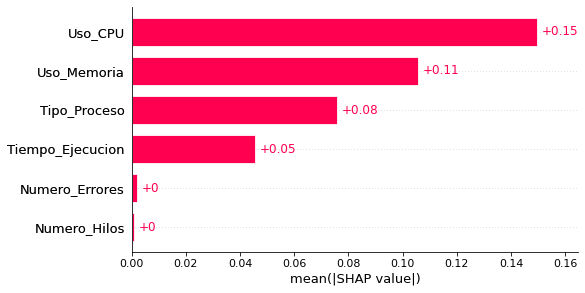

In [71]:
shap.plots.bar(shap_values)

#### Usando Shap podemos observar que las variables mas influyentes en la predicción de procesos problemáticos son: Uso_CPU y Uso_Memoria, esto ya lo habiamos observado en la matriz de correlación. El presente modelo se puede utilizar en un servidor para optimizar su rendimiento asegurando siempre que sólo se ejecuten procesos no problemáticos y así evitando el mal uso de los recursos: memoria y CPU.

## Glosario

### Accuracy
Es una métrica de ML que mide la proporción de predicciones correctas realizadas por un modelo sobre el número total de predicciones realizadas. Es una de las métricas más utilizadas para evaluar el desempeño de un modelo de clasificación.

<b>Accuracy = (# de prediciones correctas) / (# total de predicciones)

### Recall
Esto también se le llama Sensibilidad. Esto indica de todas las instancias que realmente pertenecen a una clase (Verdaderos Positivos + Falsos Negativos), cuántas se clasificaron correctamente. Esto indica la capacidad de un modelo para clasificar correctamente las instancias de una clase particular.

<b>Recall = Verdaderos Positivos / (Verdaderos Positivos + Falsos Negativos)

### Precision
Esta métrica mide de todas las instancias clasificadas con una clase particular (verdaderos positivos + falsos positivos) cuántas instancias realmente pertenecen a la clase. Si nuestro modelo clasifica algo como positivo, la precisión indica qué tan seguros podemos estar de que realmente es positivo.

<b>Precision = Verdaderos Positivos / (Verdaderos Positivos + Falsos Positivos)

### F1 score
Es una métrica de la exactitud de un modelo que tiene en cuenta tanto la Precision como el Recall, 
donde el objetivo es clasificar las instancias correctamente como positivas o negativas. La Precision mide cuántos de los 
casos positivos predecidos fueron realmente positivos, mientras que el Recall mide cuántos de los casos positivos reales 
se predijeron correctamente. Una Precision alta significa que el modelo tiene una tasa baja de falsos positivos, 
mientras que una puntuación de Recall alta significa que el modelo tiene una tasa baja de falsos negativos.

<b> F1 = 2 * (precision * recall) / (precision + recall)

### ROC AUC
Son métricas de ML que se utilizan para evaluar el rendimiento de los modelos de clasificación binaria. La curva ROC es un gráfico de la tasa de verdaderos positivos (TPR) frente a la tasa de falsos positivos (FPR) en varias configuraciones de umbral, y se crea variando el umbral para predecir un resultado positivo o negativo y trazando la TPR frente a la FPR para cada umbral. El TPR es la proporción de muestras positivas reales que el modelo identifica correctamente como positivas. Por el contrario, el FPR es la proporción de muestras negativas reales que el modelo identifica incorrectamente como positivas. En la siguiente figura, cada línea coloreada representa la curva ROC de un sistema clasificador binario diferente. Los ejes representan el FPR y el TPR. La línea diagonal representa un clasificador aleatorio, mientras que la esquina superior izquierda representa un clasificador perfecto con TPR=1 y FPR=0.

<img src="ROC.png" width=300 height=300 />

## 6) Reporte: 
Prepare un informe detallado que cubra todos los pasos realizados, desde el EDA hasta la interpretación de los resultados, incluyendo cualquier insight relevante obtenido durante el proceso.

<b>Se puede considerar como el reporte este notebook, ya que el codigo tiene comentarios de lo que se realizó. tambien esta tarea será publicada en Medium.<b/>